<a href="https://colab.research.google.com/github/Bhavana0929/WordEmbedding_from_scratch/blob/main/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Word Vectors from Scratch with Dummy and Small Corpus**

**Packages**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import sequence

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import random

from collections import deque
import matplotlib.pyplot as plt

import json

In [2]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Importing our corpus and preprocessing**

In [4]:
# Example usage
file_path = '/content/drive/MyDrive/NLP/small_corpus.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

In [5]:
def extract_unique_words(text):
  # Lowercase and tokenize the text
  text = text.lower()
  words = word_tokenize(text)

  # Remove punctuation
  words = [word for word in words if word.isalpha()]

  # Count the number of words and unique words
  print("# of words in the text: ",len(words))

  unique_words = sorted(set(words))
  print("# of unique words in the text: ",len(unique_words))

  return unique_words

In [6]:
unique_words = extract_unique_words(text)

# of words in the text:  210000
# of unique words in the text:  20


In [7]:
def generate_cbows(text,window_size):
  # Lowercase and tokenize the text
  text = text.lower()
  words = word_tokenize(text)

  # Remove punctuation
  words = [word for word in words if word.isalpha()]

  # Remove stop words
  stop_words = set(stopwords.words("english"))
  words = [word for word in words if word not in stop_words]

  # Create CBOW pairs with a given window size
  cbows = []
  for i,target_word in enumerate(words):
    context_words = words[max(0,i-window_size):i] + words[i+1:i+window_size+1]
    if len(context_words) == window_size * 2:
      cbows.append((context_words,target_word))
  return cbows

In [8]:
# Create cbows
cbows = generate_cbows(text, window_size=3)

# Display the results
for context_words, target_word in cbows[:3]:
    print(f'Context Words: {context_words}, Target Word: {target_word}')

Context Words: ['house', 'sleep', 'cat', 'play', 'animal', 'dog'], Target Word: pet
Context Words: ['sleep', 'cat', 'pet', 'animal', 'dog', 'dog'], Target Word: play
Context Words: ['cat', 'pet', 'play', 'dog', 'dog', 'cat'], Target Word: animal


In [9]:
len(cbows)

209994

In [10]:
def one_hot_encoding(word,unique_words):
  encoding = [1 if word==w else 0 for w in unique_words]
  return tf.convert_to_tensor(encoding,dtype=tf.float32)

# Create one-hot encodings for each word
one_hot_encodings = {word: one_hot_encoding(word,unique_words) for word in unique_words}

In [11]:
one_hot_encodings["pet"]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0.], dtype=float32)>

In [12]:
# Convert CBOW pairs to vector pairs
cbow_vector_pairs = [([one_hot_encodings[word] for word in context_words],one_hot_encodings[target_word]) for context_words, target_word in cbows]

In [13]:
cbow_vector_pairs[0]

([<tf.Tensor: shape=(20,), dtype=float32, numpy=
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0.], dtype=float32)>,
  <tf.Tensor: shape=(20,), dtype=float32, numpy=
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1.], dtype=float32)>,
  <tf.Tensor: shape=(20,), dtype=float32, numpy=
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.], dtype=float32)>,
  <tf.Tensor: shape=(20,), dtype=float32, numpy=
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0.], dtype=float32)>,
  <tf.Tensor: shape=(20,), dtype=float32, numpy=
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.], dtype=float32)>,
  <tf.Tensor: shape=(20,), dtype=float32, numpy=
  array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.], dtype=float32)>],
 <tf.Tens

**Converting the dataset to Tensorflow Dataset**

In [14]:
import tensorflow as tf
import numpy as np
import random

class CustomDataset(tf.data.Dataset):
  def __new__(cls,data,context_size):
    # Changed how the data was formated to reflect the context size
    inputs = np.array([[item for item in context] for context,_ in data])
    outputs = np.array([target for _,target in data])
    dataset = tf.data.Dataset.from_tensor_slices((inputs,outputs))
    return dataset

In [15]:
# Shuffle pairs before training
random.shuffle(cbow_vector_pairs)

# Train-Test Split(90% - 10%)
split_index = int(len(cbow_vector_pairs)*0.90)

# Create TensorFlow datasets
# We add the window size here as we need to know the context size
train_dataset = CustomDataset(cbow_vector_pairs[:split_index],context_size=6)
test_dataset = CustomDataset(cbow_vector_pairs[split_index:],context_size=6)

# Set batch size
# Changed from 64 to 8 to account for small size of data.
batch_size = 64

# Create DataLoader for training and validation sets
train_dataloader = train_dataset.batch(batch_size).shuffle(buffer_size=1000)
validation_dataloader = test_dataset.batch(batch_size)

**Naive Word2Vec Model**

In [16]:
class NaiveWord2Vec(tf.keras.Model):
  def __init__(self,VOCAB_SIZE,VECTOR_DIM):
    super(NaiveWord2Vec,self).__init__()
    # Use Dense layers for W1 and W2 instead of tf.Variable
    self.W1 = layers.Dense(VECTOR_DIM,input_shape=(VOCAB_SIZE,),use_bias=False) # Word Vectors. No Bias needed
    self.W2 = layers.Dense(VOCAB_SIZE,use_bias=False) # Context Prediction. No Bias needed

  def call(self,X):
    # Sum the one-hot encodings for each context in the batch along the correct axis
    # Changed the axis from 1 to 0 to reflect the context dimension
    X = tf.reduce_sum(X, axis=1) #We are summing over the context dimension to get our word embedding
    X = self.W1(X) # Convert one-hot to word embedding
    X = self.W2(X)  # Convert embedding to context scores
    return X  # Logits before softmax


**Training the model**

In [17]:
def train_model(model, train_dataloader, validation_dataloader, epochs, learning_rate, verbose=False):
    # Loss function and optimizer
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Logs
    train_set_loss_log = []
    validation_set_loss_log = []

    for epoch in range(epochs):
        if verbose: print("Epoch:", epoch)

        # Training Loop
        total_train_loss = 0.0
        num_train_batches = 0

        for inputs_batch, outputs_batch in train_dataloader:
            with tf.GradientTape() as tape:
                y_train_logits = model(inputs_batch)
                train_loss = loss_fn(outputs_batch, y_train_logits)

            # Compute gradients and update weights
            gradients = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            total_train_loss += train_loss.numpy()
            num_train_batches += 1

        # Compute average training loss
        average_train_loss = total_train_loss / num_train_batches
        train_set_loss_log.append(average_train_loss)

        # Validation Loop
        total_validation_loss = 0.0
        num_validation_batches = 0

        for inputs_batch, outputs_batch in validation_dataloader:
            y_val_logits = model(inputs_batch)
            validation_loss = loss_fn(outputs_batch, y_val_logits)

            total_validation_loss += validation_loss.numpy()
            num_validation_batches += 1

        # Compute average validation loss
        average_validation_loss = total_validation_loss / num_validation_batches
        validation_set_loss_log.append(average_validation_loss)

        if verbose:
            print(f"Train Loss: {average_train_loss:.4f} ||| Validation Loss: {average_validation_loss:.4f}")

    return model, train_set_loss_log, validation_set_loss_log

In [23]:
VOCAB_SIZE = len(unique_words)
VECTOR_DIM = 2

# Initialize Model
model = NaiveWord2Vec(VOCAB_SIZE, VECTOR_DIM)

# Train Model
model, train_set_loss_log, validation_set_loss_log = train_model(model, train_dataloader, validation_dataloader,
                                                                 epochs=3, learning_rate=0.01, verbose=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch: 0
Train Loss: 1.8988 ||| Validation Loss: 1.8613
Epoch: 1
Train Loss: 1.8583 ||| Validation Loss: 1.8541
Epoch: 2
Train Loss: 1.8560 ||| Validation Loss: 1.8497


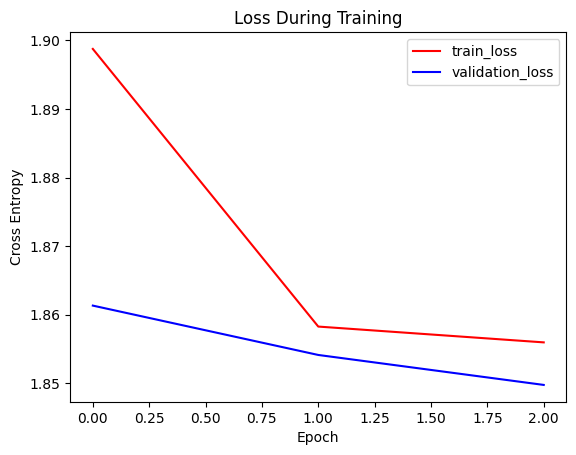

In [32]:
plt.plot(train_set_loss_log, color='red', label='train_loss')
plt.plot(validation_set_loss_log, color='blue', label='validation_loss')

plt.title("Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
plt.legend()
plt.show()

In [25]:
# Word Vectors
#Changed to model.trainable_variables as this method exists
params = model.trainable_variables
# We take the first set of weights which are W1 in the model.
word_vectors = params[0].numpy()

# Create a dictionary with the same order mapping
word_dict = {word: vector for word,vector in zip(unique_words,word_vectors)}

In [26]:
print(word_dict)

{'animal': array([ 0.89841866, -4.2046027 ], dtype=float32), 'boy': array([1.0227545, 0.2884749], dtype=float32), 'castle': array([-0.36040527,  0.13475248], dtype=float32), 'cat': array([ 0.20875217, -0.953534  ], dtype=float32), 'country': array([-0.05772479,  0.16159487], dtype=float32), 'crown': array([-0.2564277 ,  0.09749014], dtype=float32), 'dog': array([ 0.1323337, -1.0403186], dtype=float32), 'empire': array([-1.5988265,  2.7341409], dtype=float32), 'family': array([1.4055238 , 0.35279757], dtype=float32), 'father': array([1.5558255 , 0.47039288], dtype=float32), 'girl': array([1.016589 , 0.2802662], dtype=float32), 'house': array([-1.1609197 ,  0.41400334], dtype=float32), 'king': array([-0.1761271 ,  0.21232796], dtype=float32), 'marriage': array([0.7724645 , 0.26959455], dtype=float32), 'mother': array([1.1893506 , 0.22959043], dtype=float32), 'pet': array([ 0.21179108, -0.8339276 ], dtype=float32), 'play': array([ 0.23208854, -0.8622652 ], dtype=float32), 'queen': array([

**Evaluating the Word Vectors**

In [24]:
def cosine_similarity(v1,v2):
  return (v1 @ v2)/(tf.norm(v1)*tf.norm(v2))

def most_similar(word, word_dict, top_k=5):
    if word not in word_dict:
        raise ValueError(f"{word} not found in the word dictionary.")

    query_vector = word_dict[word]

    # Calculate cosine similarity with all other words in the dictionary
    similarities = {}
    for other_word, other_vector in word_dict.items():
        if other_word != word:
            similarity = cosine_similarity(query_vector, other_vector)
            similarities[other_word] = similarity.numpy() # we need to call numpy as it returns a tensor

    # Sort the words by similarity in descending order
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Get the top-k most similar words
    top_similar_words = sorted_similarities[:top_k]

    return top_similar_words

In [27]:
most_similar('dog', word_dict)

[('animal', 0.9964755),
 ('cat', 0.9960423),
 ('sleep', 0.99398214),
 ('pet', 0.9925449),
 ('play', 0.9907114)]

In [28]:
most_similar('father', word_dict)

[('boy', 0.9998255),
 ('girl', 0.99969757),
 ('marriage', 0.9991104),
 ('family', 0.9988637),
 ('mother', 0.9947093)]

In [29]:
most_similar('queen', word_dict)

[('rule', 0.9929375),
 ('house', 0.7755537),
 ('castle', 0.7658425),
 ('crown', 0.76228726),
 ('king', 0.34461367)]

In [30]:
cosine_similarity(word_dict['father'], word_dict['mother'])

<tf.Tensor: shape=(), dtype=float32, numpy=0.994709312915802>

In [31]:
cosine_similarity(word_dict['family'], word_dict['empire'])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.2794431149959564>

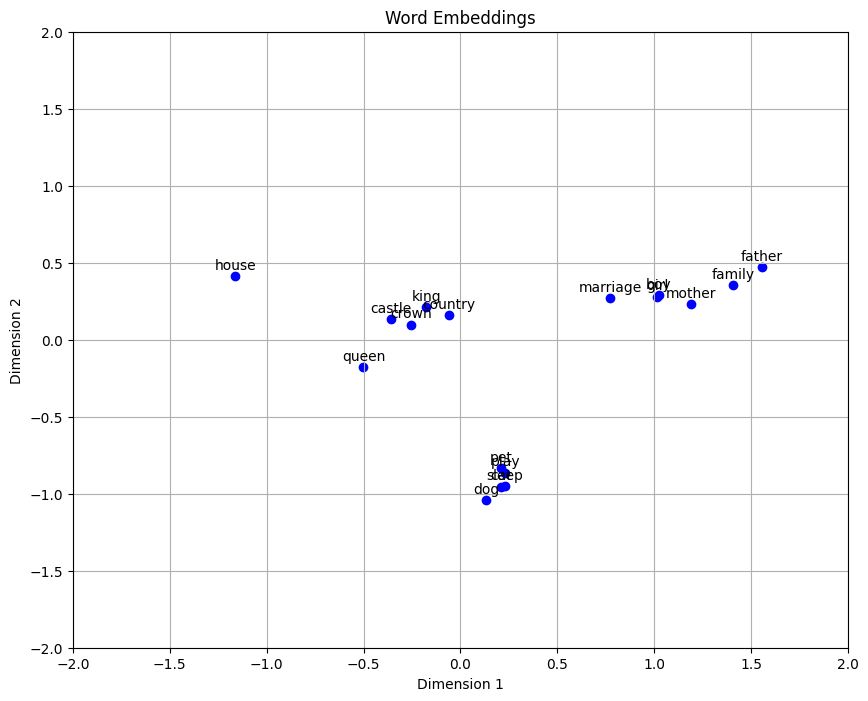

In [34]:
x_coords, y_coords = zip(*[word_dict[word] for word in list(word_dict.keys())])

plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, marker='o', color='blue')

for i, word in enumerate(list(word_dict.keys())):
    plt.annotate(word, (x_coords[i], y_coords[i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()

**Export Word Vectors**

In [35]:
import json
import numpy as np

# Specify the file path where you want to save the JSON file
file_path = 'pretrained_word_vectors.json'

# Convert numpy.ndarray objects to lists
word_vec_for_export = word_dict.copy()  # Create a copy to avoid modifying the original dictionary
for key, value in word_vec_for_export.items():
    if isinstance(value, np.ndarray): # We check to see if they are numpy arrays
        word_vec_for_export[key] = value.tolist() #We turn it into a list.

# Use json.dump to write the modified dictionary to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(word_vec_for_export, json_file, indent=2) #We use the indent for readability

print(f'Dictionary has been exported to {file_path}')

Dictionary has been exported to pretrained_word_vectors.json


In [36]:
!cp pretrained_word_vectors.json /content/drive/MyDrive/NLP/pretrained_word_vectors.json